In [28]:
%matplotlib inline

import os
import pandas as pd
import sys
import logging

## modules
sys.path.insert(0, './_modules')
from scanner_module import scanner, decode
from regex_module import FindEmail, FindNumbersBraket, FindLawsuit
from general_functions import DateConv, language
from Gmail_module import  PrintMail, FindEmail
from orchestra_module import get_table


from datetime import datetime
from datetime import timedelta
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
import pyzbar.pyzbar as pyzbar
import cv2
from langdetect import detect
from tqdm import tqdm
import ast

plt.style.use('ggplot')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [29]:
def LawsuitExtractor(data_list):
    
    lawsuit_list = []
    for item in data_list:
        if type(item) == bytes:
            item = item.decode('utf-8')
        lawsuit = FindLawsuit(item)
        lawsuit_list.append(lawsuit)
        
    return lawsuit_list

In [30]:
def GetExt(input_text):
    '''
    Returns the extension of a given filename.
    '''
    if '.' in input_text:
        
        ext = input_text.split('.')[-1]
        
      
    else:
        ext = ''
        
    return ext

In [31]:
datetime.today()

datetime.datetime(2020, 3, 7, 0, 58, 10, 133641)

In [32]:
cwd = os.getcwd()
print(cwd)

## specifying the path to database:
attachments_path = os.path.join(cwd, '_attachments')
print(attachments_path)
if os.path.isdir(attachments_path) == False:
    os.mkdir(attachments_path)
    print('Folder created!')
else:
    print('Folder already exists!')

/home/dev/sigo
/home/dev/sigo/_attachments
Folder already exists!


In [33]:
## specifying the path to collect control:
control_path = os.path.join(cwd, '_collect_control')
print(control_path)
if os.path.isdir(control_path) == False:
    os.mkdir(control_path)
    print('Folder created!')
else:
    print('Folder already exists!')

/home/dev/sigo/_collect_control
Folder already exists!


In [34]:
df_full = get_table('screening_table', option = 'full')

## converting to time object
df_full['mail_hms_received'] = pd.to_datetime(df_full['mail_hms_received']).dt.time

## converting to datetime object
df_full['mail_date_received'] = pd.to_datetime(df_full['mail_date_received'])


## unifying date and time columns into one single datetime object:
df_full['mail_datetime_received'] = pd.to_datetime(df_full['mail_date_received'].apply(str) +\
                                              ' ' + df_full['mail_hms_received'].apply(str))

df_full['mail_datetime_received'] = pd.to_datetime(df_full['mail_datetime_received'])

/home/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  after removing the cwd from sys.path.


In [35]:
df_full

,main_id,mail_id,thread_id,mail_date_received,mail_hms_received,mail_subject,mail_from,mail_body,mail_body_snippet,has_attachment,attachment_folder_link,case_id,external_ref_number,date_created,date_updated,mail_datetime_received
0,1,16e621b40e2a0718,16e3d0dba31c9f02,2019-11-13,00:13:02,Re: RES: [0-9150000028251] Referente ao Pedido...,lis-latam@google.com,"b'Hi all,\r\n\r\nAttached the response letter ...","Hi all, Attached the response letter for this ...",1,None,0-9150000028251,,2020-03-03 11:18:03,2020-03-03 11:18:03,2019-11-13 00:13:02
1,2,16d5f62086593562,16d2ce551f3bb65a,2019-09-23,18:28:42,Re: [6-5526000027768] - URGENT - 24 HOURS - OV...,lis-latam@google.com,"b'Hi all,\r\n\r\nAttached the response letter ...","Hi all, Attached the response letter for this ...",1,None,6-5526000027768,0000904-07.2019.8.17.0260,2020-03-03 11:18:03,2020-03-03 11:18:03,2019-09-23 18:28:42
2,3,16c0626420c86643,16bfb3ebc5852120,2019-07-18,17:34:13,Re: (TAÍS PLS READ) [1-0673000027027] 2019/07/...,tatesser@google.com,"b""Oi Vitor,\r\n\r\nComo falamos, vamos produzi...","Oi Vitor, Como falamos, vamos produzir os dado...",0,None,1-0673000027027,,2020-03-03 11:18:03,2020-03-03 11:18:03,2019-07-18 17:34:13
3,4,16eb93bc25e0f323,16eb93bc25e0f323,2019-11-29,22:15:31,FWD: [5-0366000028367] OFICIO 007900-8/2019,lis-latam@google.com,"b'\r\n\r\nUrgent - Fines\r\n\r\nHi team,\r\n\r...","Urgent - Fines Hi team, Please see below the r...",1,None,5-0366000028367,,2020-03-03 11:18:03,2020-03-03 11:18:03,2019-11-29 22:15:31
4,5,1700ca8ed5948627,16fe9671f13a5e14,2020-02-03,20:06:01,Re: [0-5710000029462] - LEGAL ISSUE - c 2020/0...,lis-latam@google.com,"b'\r\n\r\nHi all,\r\n\r\n\r\nAttached the resp...","Hi all, Attached the response letter for this ...",1,None,0-5710000029462,,2020-03-03 11:18:03,2020-03-03 11:18:03,2020-02-03 20:06:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13242,13243,170b248754a94357,170b248754a94357,2020-03-06,23:57:32,[5-4053000029468] - LEGAL ISSUE - c 2020/03/10...,helena.rossi@carinaquito.com,b'*Last Name*: 1\xc2\xaa Vara Federal Criminal...,Last Name: 1ª Vara Federal Criminal de Vitória...,1,None,5-4053000029468,5004766-50.2020.4.02.5001,2020-03-07 00:02:04,2020-03-07 00:02:04,2020-03-06 23:57:32
13243,13244,170b24d34803dc82,170b24d34803dc82,2020-03-07,00:02:44,[1-2667000029677] - c 2020/03/16 - FINES - Mar...,helena.rossi@carinaquito.com,b'*Last Name: *13\xc2\xaa Vara Federal de Curi...,Last Name: 13ª Vara Federal de Curitiba/PR Cou...,1,None,1-2667000029677,5010355-54.2018.4.04.7000,2020-03-07 00:07:11,2020-03-07 00:07:11,2020-03-07 00:02:44
13244,13245,170b2589ddc3c9b5,170b2589ddc3c9b5,2020-03-07,00:15:15,FWD: [0-1687000029943] BR Data Request: Autos ...,lis-latam@google.com,b'\r\n\r\nUrgent - 72hr\r\n\r\nRecords # [Auto...,Urgent - 72hr Records # [Autos n° 0000906-66.2...,1,None,0-1687000029943,0000906-66.2020.8.16.0131,2020-03-07 00:17:20,2020-03-07 00:17:20,2020-03-07 00:15:15
13245,13246,170b25e7d3f0f38a,170b25e7d3f0f38a,2020-03-07,00:21:41,FWD: [5-2039000029785] BR Data Request 5063145...,lis-latam@google.com,b'\r\n\r\nUrgent - Fines\r\n\r\nDate received ...,Urgent - Fines Date received via LERS: March 6...,1,None,5-2039000029785,,2020-03-07 00:22:28,2020-03-07 00:22:28,2020-03-07 00:21:41


In [36]:
df_att = pd.read_csv(os.path.join(control_path, 'att_data.csv'), sep ='\t', encoding = 'utf-8')

In [37]:
df_att

,mail_id,doc_name,doc_link
0,16e7f52e8897940d,316:2019.pdf,/home/dev/sigo/_attachments/16e7f52e8897940d/3...
1,16efbfe76f3c98a7,02367-2019_Redacted.pdf,/home/dev/sigo/_attachments/16efbfe76f3c98a7/0...
2,16c73a4539a90832,Court Order #6429.pdf,/home/dev/sigo/_attachments/16c73a4539a90832/C...
3,16ea8eba4927ca92,592-2019_Redacted.pdf,/home/dev/sigo/_attachments/16ea8eba4927ca92/5...
4,16fe846f16206c67,01 2020_Redacted.pdf,/home/dev/sigo/_attachments/16fe846f16206c67/0...
...,...,...,...
20574,170b24d34803dc82,Court Order #8286.pdf,/home/dev/sigo/_attachments/170b24d34803dc82/C...
20575,170b2589ddc3c9b5,09:2020__Redacted.pdf,/home/dev/sigo/_attachments/170b2589ddc3c9b5/0...
20576,170b25e7d3f0f38a,510002429849___Redacted.pdf,/home/dev/sigo/_attachments/170b25e7d3f0f38a/5...
20577,170b2725328bebdc,Court_Letter.pdf,/home/dev/sigo/_attachments/170b2725328bebdc/C...


In [38]:
df_to = pd.read_csv(os.path.join(control_path, 'to_data.csv'), sep ='\t', encoding = 'utf-8')

In [39]:
df_to

,mail_id,destinatary_mail
0,16e7f52e8897940d,google@carinaquito.com
1,16e7f52e8897940d,alice.matsuo@carinaquito.com
2,16e7f52e8897940d,carina.quito@carinaquito.com
3,16e7f52e8897940d,isla.santos@carinaquito.com
4,16e7f52e8897940d,rafael.kohl@carinaquito.com
...,...,...
211517,170b2725328bebdc,rafael.kohl@carinaquito.com
211518,170b2725328bebdc,mohamad.fares@carinaquito.com
211519,170b2725328bebdc,petrya.alves@carinaquito.com
211520,170b2725328bebdc,guilherme.savoldi@carinaquito.com


In [40]:
df_att

,mail_id,doc_name,doc_link
0,16e7f52e8897940d,316:2019.pdf,/home/dev/sigo/_attachments/16e7f52e8897940d/3...
1,16efbfe76f3c98a7,02367-2019_Redacted.pdf,/home/dev/sigo/_attachments/16efbfe76f3c98a7/0...
2,16c73a4539a90832,Court Order #6429.pdf,/home/dev/sigo/_attachments/16c73a4539a90832/C...
3,16ea8eba4927ca92,592-2019_Redacted.pdf,/home/dev/sigo/_attachments/16ea8eba4927ca92/5...
4,16fe846f16206c67,01 2020_Redacted.pdf,/home/dev/sigo/_attachments/16fe846f16206c67/0...
...,...,...,...
20574,170b24d34803dc82,Court Order #8286.pdf,/home/dev/sigo/_attachments/170b24d34803dc82/C...
20575,170b2589ddc3c9b5,09:2020__Redacted.pdf,/home/dev/sigo/_attachments/170b2589ddc3c9b5/0...
20576,170b25e7d3f0f38a,510002429849___Redacted.pdf,/home/dev/sigo/_attachments/170b25e7d3f0f38a/5...
20577,170b2725328bebdc,Court_Letter.pdf,/home/dev/sigo/_attachments/170b2725328bebdc/C...


In [41]:
df_att['extension'] = df_att['doc_name'].apply(GetExt)

In [42]:
df_att['extension'].value_counts()

pdf            20212
docx             123
eml               62
PDF               52
jpeg              46
gif               30
zip               18
xls               10
doc                6
xlsx               6
PNG                4
53                 2
msg                2
JPG                2
11000003107        2
                   2
Name: extension, dtype: int64

In [43]:
## using only files in the current machine:
df_att_local = df_att[df_att['doc_link'].str.contains(cwd) == True]
len(df_att_local)

20579

In [44]:
df_att_sample = df_att_local.sample(50)

In [45]:
df_att_sample

,mail_id,doc_name,doc_link,extension
7848,16efae6e9e842c3b,3164148.pdf,/home/dev/sigo/_attachments/16efae6e9e842c3b/3...,pdf
3869,16c4d7e644593a20,0001431-40.2019.8.26.0346.pdf,/home/dev/sigo/_attachments/16c4d7e644593a20/0...,pdf
16631,16c9b67d1b778817,62-2019_Redacted.pdf,/home/dev/sigo/_attachments/16c9b67d1b778817/6...,pdf
2194,17069fe4c6ddaf7c,Court Order #8175.pdf,/home/dev/sigo/_attachments/17069fe4c6ddaf7c/C...,pdf
12955,16c68b5c7fca08a5,2660-2019_Redacted.pdf,/home/dev/sigo/_attachments/16c68b5c7fca08a5/2...,pdf
11935,16dbc12c1b637089,2174358-2019_Redacted.pdf,/home/dev/sigo/_attachments/16dbc12c1b637089/2...,pdf
2821,16b9ed86c6337348,#5662 - protocolo Delegacia de Homicídios de N...,/home/dev/sigo/_attachments/16b9ed86c6337348/#...,pdf
9170,16ddba7b41058742,770517-Reiteration.pdf,/home/dev/sigo/_attachments/16ddba7b41058742/7...,pdf
2692,1701ce40fa92ee48,Court Order #8010.pdf,/home/dev/sigo/_attachments/1701ce40fa92ee48/C...,pdf
18030,16eddc027b676eb5,Court Order #7604.pdf,/home/dev/sigo/_attachments/16eddc027b676eb5/C...,pdf


In [46]:
df_att_sample['qr_code'] = df_att_sample['doc_link'].progress_apply(decode)


100%|██████████| 50/50 [02:26<00:00,  2.92s/it]


In [47]:
df_att_sample

,mail_id,doc_name,doc_link,extension,qr_code
7848,16efae6e9e842c3b,3164148.pdf,/home/dev/sigo/_attachments/16efae6e9e842c3b/3...,pdf,[]
3869,16c4d7e644593a20,0001431-40.2019.8.26.0346.pdf,/home/dev/sigo/_attachments/16c4d7e644593a20/0...,pdf,[]
16631,16c9b67d1b778817,62-2019_Redacted.pdf,/home/dev/sigo/_attachments/16c9b67d1b778817/6...,pdf,[]
2194,17069fe4c6ddaf7c,Court Order #8175.pdf,/home/dev/sigo/_attachments/17069fe4c6ddaf7c/C...,pdf,[]
12955,16c68b5c7fca08a5,2660-2019_Redacted.pdf,/home/dev/sigo/_attachments/16c68b5c7fca08a5/2...,pdf,"[b'PJZZVGJRQMJ6E6MNYHXA', b'PJZZVGJRQMJ6E6MNYH..."
11935,16dbc12c1b637089,2174358-2019_Redacted.pdf,/home/dev/sigo/_attachments/16dbc12c1b637089/2...,pdf,[]
2821,16b9ed86c6337348,#5662 - protocolo Delegacia de Homicídios de N...,/home/dev/sigo/_attachments/16b9ed86c6337348/#...,pdf,[]
9170,16ddba7b41058742,770517-Reiteration.pdf,/home/dev/sigo/_attachments/16ddba7b41058742/7...,pdf,[]
2692,1701ce40fa92ee48,Court Order #8010.pdf,/home/dev/sigo/_attachments/1701ce40fa92ee48/C...,pdf,[]
18030,16eddc027b676eb5,Court Order #7604.pdf,/home/dev/sigo/_attachments/16eddc027b676eb5/C...,pdf,[]


In [48]:
df_att_sample['external_ref_number_list'] = df_att_sample['qr_code'].apply(LawsuitExtractor)

In [49]:
df_att_sample

,mail_id,doc_name,doc_link,extension,qr_code,external_ref_number_list
7848,16efae6e9e842c3b,3164148.pdf,/home/dev/sigo/_attachments/16efae6e9e842c3b/3...,pdf,[],[]
3869,16c4d7e644593a20,0001431-40.2019.8.26.0346.pdf,/home/dev/sigo/_attachments/16c4d7e644593a20/0...,pdf,[],[]
16631,16c9b67d1b778817,62-2019_Redacted.pdf,/home/dev/sigo/_attachments/16c9b67d1b778817/6...,pdf,[],[]
2194,17069fe4c6ddaf7c,Court Order #8175.pdf,/home/dev/sigo/_attachments/17069fe4c6ddaf7c/C...,pdf,[],[]
12955,16c68b5c7fca08a5,2660-2019_Redacted.pdf,/home/dev/sigo/_attachments/16c68b5c7fca08a5/2...,pdf,"[b'PJZZVGJRQMJ6E6MNYHXA', b'PJZZVGJRQMJ6E6MNYH...","[, , , , ]"
11935,16dbc12c1b637089,2174358-2019_Redacted.pdf,/home/dev/sigo/_attachments/16dbc12c1b637089/2...,pdf,[],[]
2821,16b9ed86c6337348,#5662 - protocolo Delegacia de Homicídios de N...,/home/dev/sigo/_attachments/16b9ed86c6337348/#...,pdf,[],[]
9170,16ddba7b41058742,770517-Reiteration.pdf,/home/dev/sigo/_attachments/16ddba7b41058742/7...,pdf,[],[]
2692,1701ce40fa92ee48,Court Order #8010.pdf,/home/dev/sigo/_attachments/1701ce40fa92ee48/C...,pdf,[],[]
18030,16eddc027b676eb5,Court Order #7604.pdf,/home/dev/sigo/_attachments/16eddc027b676eb5/C...,pdf,[],[]


In [50]:
#df_att_sample.to_csv('extracting_att_test.csv', sep = '\t', encoding = 'utf-8', index = False)

In [51]:
#df_att_sample = pd.read_csv('extracting_att_test.csv', sep = '\t', encoding = 'utf-8')

In [52]:
df_att_sample

,mail_id,doc_name,doc_link,extension,qr_code,external_ref_number_list
7848,16efae6e9e842c3b,3164148.pdf,/home/dev/sigo/_attachments/16efae6e9e842c3b/3...,pdf,[],[]
3869,16c4d7e644593a20,0001431-40.2019.8.26.0346.pdf,/home/dev/sigo/_attachments/16c4d7e644593a20/0...,pdf,[],[]
16631,16c9b67d1b778817,62-2019_Redacted.pdf,/home/dev/sigo/_attachments/16c9b67d1b778817/6...,pdf,[],[]
2194,17069fe4c6ddaf7c,Court Order #8175.pdf,/home/dev/sigo/_attachments/17069fe4c6ddaf7c/C...,pdf,[],[]
12955,16c68b5c7fca08a5,2660-2019_Redacted.pdf,/home/dev/sigo/_attachments/16c68b5c7fca08a5/2...,pdf,"[b'PJZZVGJRQMJ6E6MNYHXA', b'PJZZVGJRQMJ6E6MNYH...","[, , , , ]"
11935,16dbc12c1b637089,2174358-2019_Redacted.pdf,/home/dev/sigo/_attachments/16dbc12c1b637089/2...,pdf,[],[]
2821,16b9ed86c6337348,#5662 - protocolo Delegacia de Homicídios de N...,/home/dev/sigo/_attachments/16b9ed86c6337348/#...,pdf,[],[]
9170,16ddba7b41058742,770517-Reiteration.pdf,/home/dev/sigo/_attachments/16ddba7b41058742/7...,pdf,[],[]
2692,1701ce40fa92ee48,Court Order #8010.pdf,/home/dev/sigo/_attachments/1701ce40fa92ee48/C...,pdf,[],[]
18030,16eddc027b676eb5,Court Order #7604.pdf,/home/dev/sigo/_attachments/16eddc027b676eb5/C...,pdf,[],[]


In [55]:
#df_att_sample['qr_code'] = df_att_sample['qr_code'].progress_apply(ast.literal_eval)

In [56]:
#df_att_sample['external_ref_number_list'] = df_att_sample['external_ref_number_list']\
#.progress_apply(ast.literal_eval)

In [58]:
df_att_sample

,mail_id,doc_name,doc_link,extension,qr_code,external_ref_number_list
7848,16efae6e9e842c3b,3164148.pdf,/home/dev/sigo/_attachments/16efae6e9e842c3b/3...,pdf,[],[]
3869,16c4d7e644593a20,0001431-40.2019.8.26.0346.pdf,/home/dev/sigo/_attachments/16c4d7e644593a20/0...,pdf,[],[]
16631,16c9b67d1b778817,62-2019_Redacted.pdf,/home/dev/sigo/_attachments/16c9b67d1b778817/6...,pdf,[],[]
2194,17069fe4c6ddaf7c,Court Order #8175.pdf,/home/dev/sigo/_attachments/17069fe4c6ddaf7c/C...,pdf,[],[]
12955,16c68b5c7fca08a5,2660-2019_Redacted.pdf,/home/dev/sigo/_attachments/16c68b5c7fca08a5/2...,pdf,"[b'PJZZVGJRQMJ6E6MNYHXA', b'PJZZVGJRQMJ6E6MNYH...","[, , , , ]"
11935,16dbc12c1b637089,2174358-2019_Redacted.pdf,/home/dev/sigo/_attachments/16dbc12c1b637089/2...,pdf,[],[]
2821,16b9ed86c6337348,#5662 - protocolo Delegacia de Homicídios de N...,/home/dev/sigo/_attachments/16b9ed86c6337348/#...,pdf,[],[]
9170,16ddba7b41058742,770517-Reiteration.pdf,/home/dev/sigo/_attachments/16ddba7b41058742/7...,pdf,[],[]
2692,1701ce40fa92ee48,Court Order #8010.pdf,/home/dev/sigo/_attachments/1701ce40fa92ee48/C...,pdf,[],[]
18030,16eddc027b676eb5,Court Order #7604.pdf,/home/dev/sigo/_attachments/16eddc027b676eb5/C...,pdf,[],[]


In [62]:
test_list = df_att_sample['qr_code'][10556]
test_list

[b'Autos n. 5012842-56.2019.4.03.6105\n#7886']

In [63]:
type(test_list[0].decode('utf-8'))

str

In [64]:
df_att_sample['doc_text_list'] = df_att_sample['doc_link'].progress_apply(scanner)




  0%|          | 0/50 [00:00<?, ?it/s]


  4%|▍         | 2/50 [00:04<01:55,  2.40s/it]


  6%|▌         | 3/50 [01:16<18:04, 23.08s/it]


  8%|▊         | 4/50 [01:39<17:41, 23.07s/it]


 10%|█         | 5/50 [02:32<24:06, 32.15s/it]


 12%|█▏        | 6/50 [03:12<25:22, 34.59s/it]


 14%|█▍        | 7/50 [04:13<30:21, 42.35s/it]


 16%|█▌        | 8/50 [04:30<24:26, 34.92s/it]


 18%|█▊        | 9/50 [04:35<17:45, 25.98s/it]


 20%|██        | 10/50 [06:08<30:37, 45.95s/it]


 22%|██▏       | 11/50 [06:25<24:10, 37.19s/it]


 24%|██▍       | 12/50 [07:04<23:53, 37.72s/it]


 26%|██▌       | 13/50 [07:06<16:46, 27.21s/it]


 28%|██▊       | 14/50 [09:44<39:50, 66.40s/it]


 30%|███       | 15/50 [09:52<28:26, 48.76s/it]


 32%|███▏      | 16/50 [10:09<22:19, 39.38s/it]


 34%|███▍      | 17/50 [10:18<16:35, 30.16s/it]


 36%|███▌      | 18/50 [10:21<11:48, 22.14s/it]


 38%|███▊      | 19/50 [10:49<12:15, 23.71s/it]


 40%|████      | 20/50 [14:57<45:32, 91.10s/it]


 42%|████▏    

In [66]:
df_att_sample['doc_text_list']

7848     [“ Google\n\nMountain View, 12/12/19 (MM/DD/AA...
3869     [TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO\n\...
16631    [(“º TJ DFT Poder Judiciário da União Falha nº...
2194     [PROJ UDI - Processo: 0006540-22.2019.8.16.011...
12955    [PROJUDI - Processo: 0010537-76.2018,8.16.0075...
11935    [TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO\n\...
2821     [/\n\nl\n\n(wie [. l,('\nAmphilhcauv\n“sx“ 1.1...
9170     [Google\n\nMountain View, 21 de Dezembro de 20...
2692     [fls. 568\n\n* PODER JUDICIÁRIO DO ESTADO DO C...
18030    [gaja,—4,02% %%%& %%37\n\n \n\nAutos nº—\n\nRé...
19239    [TRIBUNAL DE JUSTIÇA DO ESTADO DE SÃO PAULO\n\...
1712     [24\n\nDANIELLA ALVES\n\nADVOCACIA\n\n \n\n \n...
367      [MURILLO LEAL RG 04 20\nDIH RESERVADO '\n\nEst...
13911    [ECT - EMP. BRAS. OE CORREIOS E TELEORAFOS\n\n...
10556    [(Zou—rl» ! L ('\n\nêlthçsêlítfãkâay G o o I e...
5711     [Governo do Estado da Bahia ' N _\nSecretaria ...
11772    [“ »» Google\n\nMountain View, 09/23/19 (MM/DD.

In [ ]:
## has QR code?
#data_list = decode(img)
#print(data_list)

In [67]:
## OCRing doc:
#doc_list = scanner(img)
#print(len(doc_list))

In [68]:
df_ex = df_full[df_full['external_ref_number'].isnull() == False].reset_index(drop = True)

In [69]:
df_ex_group = df_ex.groupby('external_ref_number')['mail_id'].apply(list).to_frame().reset_index()
df_ex_group.columns = ['external_ref_number', 'mail_list']
df_ex_group['mail_counting'] = df_ex_group['mail_list'].apply(len)

In [70]:
df_ex_group['mail_counting'].describe()

count    1702.000000
mean        7.783196
std       150.963118
min         1.000000
25%         2.000000
50%         3.000000
75%         5.000000
max      6230.000000
Name: mail_counting, dtype: float64

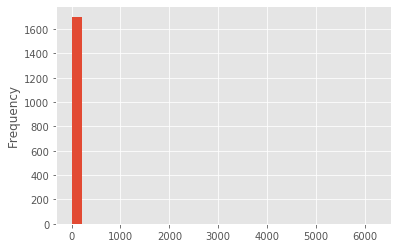

In [71]:
df_ex_group['mail_counting'].plot.hist(bins = 30)

In [72]:
test_mail_list = df_ex_group['mail_list'][15]
PrintMail(test_mail_list, df_full, full = False)

16d41320ae102d98
[1-9392000027783] - c 2019/09/23 - September 23th, 2019 - CRIMINAL - LOCATION HISTORY - LARCENY BY FRAUD - TRIX #6826
2019-09-17 00:00:00
mohamad.fares@carinaquito.com
-----------
Last Name: Vara Única da Comarca de Borborema - SP Country: BR External Reference Number: 0000091-25.2019.8.26.0067 Date the Court Order was Issued: 2019/09/09 Date Received: 2019/09/16 Due Date: 2019/
-----------
-----------
-----------
16d4a193ab39b427
Re: [1-9392000027783] - c 2019/09/23 - September 23th, 2019 - CRIMINAL - LOCATION HISTORY - LARCENY BY FRAUD - TRIX #6826
2019-09-19 00:00:00
lis-latam@google.com
-----------
Hi, Please find below our response sent directly to dpm.borborema@policiacivil.sp.gov.br. Regards, Mayara - LIS ____________________________________ Mountain View, 09/19/2019 (MM/DD/AAAA) Exmo. Senhor
-----------
-----------
-----------


In [12]:
df_full2 = df_full.dropna(subset = ['external_ref_number'])

In [13]:
df_thread_group = df_full2.groupby('thread_id')['external_ref_number'].apply(list).to_frame().reset_index()
df_thread_group.columns = ['thread_id', 'external_ref_number_list']

In [14]:
df_thread_group['external_ref_number_counting'] = df_thread_group['external_ref_number_list'].apply(len)

In [15]:
df_thread_group['external_ref_number_unique'] = df_thread_group['external_ref_number_list'].apply(set)

In [16]:
df_thread_group['external_ref_number_unique_counting'] = df_thread_group['external_ref_number_unique'].apply(len)

In [17]:
df_thread_group

,thread_id,external_ref_number_list,external_ref_number_counting,external_ref_number_unique,external_ref_number_unique_counting
0,16b8bfc73c78b51c,"[0000815-19.2019.8.21, 0000815-19.2019.8.21, 0...",37,"{0000815-19.2019.8.21, 0000815-19.2019.8.21.0083}",2
1,16bfb1a85a90c8dc,[158.528.138-77],1,{158.528.138-77},1
2,16bfd41ce1e317a1,[0019790-53.2019.8.26.0050],1,{0019790-53.2019.8.26.0050},1
3,16c0082d58a706de,[222-46.2019.4.01.4103],1,{222-46.2019.4.01.4103},1
4,16c008a545abb419,[1500834-91.2019.8.26.0541],1,{1500834-91.2019.8.26.0541},1
5,16c00a3987b594c8,"[0148820-69.2018.8.21.0001, 0148820-69.2018.8....",9,{0148820-69.2018.8.21.0001},1
6,16c010e866ecd227,[0000167-88.2019.8.17.0620],1,{0000167-88.2019.8.17.0620},1
7,16c01121888bca81,[0002178-42.2018.8.24.0067],1,{0002178-42.2018.8.24.0067},1
8,16c0126dec2fd04b,[0000384-87.2019.8.17.0570],1,{0000384-87.2019.8.17.0570},1
9,16c01761d05354b4,"[0914800-34.2019.8.12.0001, 0914800-34.2019.8....",2,{0914800-34.2019.8.12.0001},1


In [18]:
df_thread_group['external_ref_number_unique_counting'].describe()

count    3538.000000
mean        1.007349
std         0.085422
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: external_ref_number_unique_counting, dtype: float64

In [19]:
df_thread_group['external_ref_number_unique_counting'].value_counts()

1    3512
2      26
Name: external_ref_number_unique_counting, dtype: int64

In [20]:
df_case_group = df_full.groupby('case_id')['mail_id'].apply(list).to_frame().reset_index()
df_case_group.columns = ['case_id', 'mail_list']
df_case_group['mail_counting'] = df_case_group['mail_list'].apply(len)

In [21]:
df_case_group

,case_id,mail_list,mail_counting
0,0-0027000028709,"[16f6cdb6e830fc91, 16fb5beea0adb1ac, 16f823855...",3
1,0-0140000027614,"[16cf67b78156fe88, 16cf67cb04ca6ce8, 16cfe7abd...",4
2,0-0160000027608,"[16d6aa92c5a576f5, 16dcc9d9584f38e2, 16d63f2f9...",3
3,0-0191000027522,"[16d459498d81d399, 16d503191ed90d35, 16d4b4f73...",3
4,0-0196000028985,"[16fce5e753f8f4f0, 16fd2dfd8148bfb9]",2
5,0-0202000027800,"[16d6a484f59e45ba, 16d182a6362925e7, 16d0821dd...",3
6,0-0274000028494,"[16df5d73a96dffcf, 16ea3ad167161fba, 16e0071c2...",3
7,0-0306000029605,"[17059608cf89d17d, 170408829bc2cd7e, 170310958...",5
8,0-0335000027821,"[16d40f4fc3043f80, 16cf41d372c59495, 16ce3a008...",3
9,0-0341000028936,"[16f7144dfc943ae1, 16f44b3af5265111, 16f476774...",7


In [22]:
df_case_group['mail_counting'].describe()

count    2870.000000
mean        3.521603
std         1.857428
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max        25.000000
Name: mail_counting, dtype: float64

In [23]:
#mail_dict = {}
#for k in range(0, len(df_attachments)):
#    print(k)
#    try:
#        pages_list = scanner(df_attachments['doc_link'][k])
#
#        data_list = []
#        for page in pages_list:
#            if page != '':
#                lawsuit_list = FindLawsuit(page)
#                data_list.append(lawsuit_list)
#
#        key = df_attachments['mail_id'][k]
#        data_list = [item for item in data_list if item != '']
#        
#        if len(data_list) != 0:
#            mail_dict[key] = list(set(data_list))
#    except:
#        continue
        
        

    

In [24]:
os.listdir(cwd)

['.ipynb_checkpoints',
 'z_old',
 'DataIA.ipynb',
 'DataCollector_v2.py',
 '_documentation',
 'mySQL_tests',
 'docs',
 'logging_output_DataCollector.dat',
 '_data_original',
 '_external_data',
 '_attachments',
 'DataCollector.ipynb',
 'structuring_data.ipynb',
 '.gitignore',
 'exploring_data.ipynb',
 '.git',
 '_data_output',
 '_modules',
 '_collect_control',
 'output_DataCollector.dat',
 'README.md',
 'DataCollector_v2_tests.ipynb']

In [25]:
folders_list = os.listdir(attachments_path)
folders_list

['16b95ded6b8cd8ce',
 '16d98800a5b07150',
 '16e67cc8c6198ce1',
 '16c73268041c185b',
 '16e3d0b9fc966ed9',
 '16efc2cf0aee29f8',
 '1705f5364185046d',
 '16ffc5785305fc4e',
 '16cdf43d6d0c2d37',
 '16da7a52948a2ac7',
 '16f19915a07580cd',
 '16eaed344da9ca72',
 '16e1db966b4ebbdf',
 '16d829d1a08373e5',
 '16f91bcd86008cb7',
 '16dcbf46fb6f748b',
 '16eb37b0dfb0cb10',
 '16df90ec070e230d',
 '17010c1f5f913d04',
 '16dcc7a45c1c0790',
 '16e6a8cd5ea691b4',
 '16ef1c856e0415bb',
 '16cfd6a3fd0ad021',
 '16d983dcde7fe989',
 '1701307178388233',
 '16e909f69cd55385',
 '16effd29a9c85488',
 '1706a03113e2ca6e',
 '16cd04887e73838e',
 '16d2d15f1c9fea2a',
 '16fc9ddc5b57c4a6',
 '16fcce4ed2532947',
 '16cbfeda7e571b77',
 '16d07c847ee2a2c4',
 '16e24461edfe1145',
 '16e9052a865f1c0c',
 '16e7fd1e64bc656b',
 '16f0fcf8d39dd7f4',
 '170550ede0dad3a6',
 '16e90e5279d82e74',
 '16ffd4c149826426',
 '16d3f8ac18f43c67',
 '16f90a99cb045055',
 '16eb98bd052c5a1a',
 '16c9245cc2280cf8',
 '16f1e88d90b1d343',
 '16fa5b903ed4308e',
 '1701d1912c4

In [26]:
counter = 0
for folder in os.listdir(attachments_path):
    docs_list = os.listdir(os.path.join(attachments_path, folder))
    for item in docs_list:
        if item.split('.')[-1] != 'pdf':
            counter += 1
            print(folder)
            print(item)
            print(' ')

16d2c0bdc1cea329
IMG_9956.jpeg
 
16d6fb04a202174d
MODELO DE RECIBO.docx
 
1702f5f3161c6231
WhatsApp Image 2020-02-10 at 10.03.45.jpeg
 
1702f5f3161c6231
RECIBO.docx
 
1703b553f9eae38e
comprovante sedex.jpeg
 
16faa260dcbc42ca
image003.gif
 
16ff12e542d3922b
MODELO DE RECIBO.docx
 
16dcc14ce04b5282
Ordem Judicial.PDF
 
16deed637c860f83
Of 4471_2019.PDF
 
16c4edaeed701e4a
ASSINATURA CEP CORRETO.PNG
 
16fecf8a56cfc36e
MODELO DE RECIBO.docx
 
16df95f2cf40ec5e
MODELO DE RECIBO.docx
 
16cf84b0596e250f
Ordem Judicial email 164.PDF
 
16be6f95998e9253
MODELO DE RECIBO.docx
 
16d839ca9e03dfb1
Diligência - Gabinete do Ministro Raul Araújo do Superior Tribunal de Justiça.eml
 
16d8386a6a749e9e
Ordem Judicial Email.PDF
 
16c2634f5c6dc6ed
RE: [6-7210000026999] [BRA] - [Official Letter] - [July 22, 2019].eml
 
16d042e314235210
Petição_Oposição_Julgamento Virtual_HR.docx
 
16d042e314235210
Memoriais_#5079_proc.60_Dados Cadastrais_HR.docx
 
16fe809b9451e39f
MODELO DE RECIBO.docx
 
16eacec1979b320c
MODE

In [27]:
counter

164

In [28]:
#test_folder = random.choice(folders_list)
test_folder = '17035cfb81a34985'
print(test_folder)
test_file = random.choice(os.listdir(os.path.join(attachments_path, test_folder)))
print(test_file)

17035cfb81a34985
IMG-20200210-WA0006.jpeg


In [29]:
img = os.path.join(attachments_path, test_folder, test_file)
print(img)

/home/leandro/Desktop/Dropbox/sigo/_attachments/17035cfb81a34985/IMG-20200210-WA0006.jpeg


In [30]:
## has QR code?
data_list = decode(img)
print(data_list)

Type :  QRCODE
Data :  b'Autos n. 1014339-18.2019.4.01.3200\n#7591' 

[b'Autos n. 1014339-18.2019.4.01.3200\n#7591']


In [31]:
## OCRing doc:
doc_list = scanner(img)
print(len(doc_list))

1


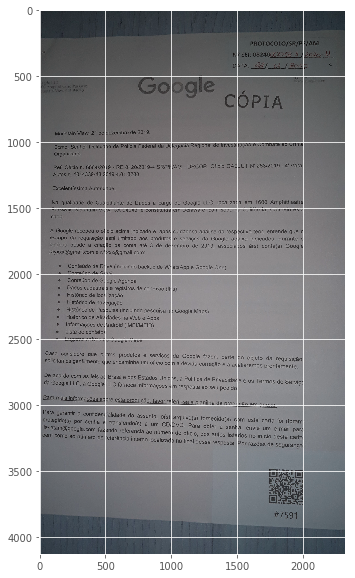

In [32]:
im = cv2.imread(img)
plt.figure(figsize = [15,10])
plt.imshow(im)
plt.show()

In [33]:
print(doc_list[0])

Ofício n. “6684/2019 - RE 0120/2019-4 SR/PF/AM - DRCOR, Ofício GABJUT N' 263/2019 - 4 Vara,
autos n. 1014339—18.2019.4.01.3200

Excelentíssima Autoridade,

Na qualidade de Custodiante de Dados a cargo de Google LLC, localizada em ,1690 Amphitheatre
Parkway, Mountain View, CA 94043, e constituída em Delaware, com sede na California, submeto esta

carta.

A Google recebeu o ofício acima indicado e, após cuidadosa análise do respectivo teor, entende que o
escopo da requisição está limitado aos produtos e serviços da Google abaixo indicados, durante o
período desde a criação da conta até 3 de dezembro de 2019, associados à(s) conta(s) Google

rayxxx©gmail.com e r.fixxx©gmail.com:

Conteúdo de Drive (incluindo backup de WhatsApp e Google One)

.
o Conteúdo de Gmail

. Conteúdo de Google Agenda
0 Dados cadastrais e registros de conexão (IPs)
. Histórico de localização
. Histórico de navegação
e Histórico de Pesquisa (incluindo pesquisa no Google Maps)
.

.

.

.

Histórico de Atividades na W

In [35]:
language(doc_list[0])

'pt'

In [43]:
df_sample = df_full.sample(100)

In [46]:
df_sample['mail_body_language'] = df_sample['mail_body_snippet'].apply(language)

In [47]:
df_sample

,mail_id,thread_id,mail_date_received_full,mail_from,mail_subject,mail_body,mail_body_snippet,has_attachment,mail_date_received,mail_hms_received,case_id,external_ref_number,mail_body_language
11727,17065b152ecaa472,17064bd49e412f76,2020-02-21 03:01:25+00:00,biancasantiago.adv@gmail.com,Re: Diligência - Delegacia de Repressão a Corr...,Bom dia!\r\n\r\nAcuso recebimento.\r\n\r\nÀ di...,Bom dia! Acuso recebimento. À disposição! Att....,0,2020-02-21,03:01:25,NaN,NaN,pt
10540,16dfa6b1d61cab34,16dad0f5897a4cd6,2019-10-23 20:59:45+00:00,lis-latam@google.com,Re: [0-1027000027969] - PETITION - URGENT - 24...,"Hi all,\r\n\r\nAttached the response letter fo...","Hi all, Attached the response letter for this ...",1,2019-10-23,20:59:45+00:00,0-1027000027969,5024217-49.2019.4.04.7100,en
12209,17053ffe53b47ca0,17053ffe53b47ca0,2020-02-17 16:34:02+00:00,lis-latam@google.com,FWD: [1-2626000029620] BR Data Request 0000587...,\r\n\r\nUrgent - 24 hour deadline - Espirito S...,Urgent - 24 hour deadline - Espirito Santo Rec...,1,2020-02-17,16:34:02,1-2626000029620,0000587-62.2020.8.08.0021,en
6273,16f91e33c2c4b4e2,16f8b8e778f3a339,2020-01-10 23:56:08+00:00,mohamad.fares@carinaquito.com,RES: [8-6449000029400] BR Data Request: IPM n ...,"Hi LIS,\r\n\r\n\r\n\r\nPlease notice that this...","Hi LIS, Please notice that this case is relate...",1,2020-01-10,23:56:08+00:00,8-6449000029400,0002711-03.2019.9.26.0010,en
752,16d8f1ceefe486dd,16d8f1ceefe486dd,2019-10-03 00:54:56+00:00,mohamad.fares@carinaquito.com,[0-6805000028221] - c 2019/10/07 - October 07t...,Last Name: 1ª Vara Criminal da Comarca de Grav...,Last Name: 1ª Vara Criminal da Comarca de Grav...,1,2019-10-03,00:54:56+00:00,0-6805000028221,0024169-83.2019.8.21.0015,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7083,16c4e661684bceed,16c3ddc49422e7e7,2019-08-01 18:16:48+00:00,lis-latam@google.com,RE: [5-9945000026251] RES: Encaminha ofício 7...,"\r\nMy apologies, find the attached file here....","My apologies, find the attached file here. On ...",1,2019-08-01,18:16:48+00:00,5-9945000026251,1500327-66.2019.8.26.0627,en
3851,16c6df308c119fae,16c6df308c119fae,2019-08-07 21:18:57+00:00,lis-latam@google.com,RE: [8-9069000027412] Google reference number ...,\r\n\r\nUrgent - 5 day deadline / Fines\r\n\r\...,"Urgent - 5 day deadline / Fines Hi team, Pleas...",1,2019-08-07,21:18:57+00:00,8-9069000027412,0028125-48.2019.827.2729,en
0,16f33f733ab079ab,16f33f733ab079ab,2019-12-23 18:13:55+00:00,lis-latam@google.com,FWD: [2-7133000028568] Número de referência Go...,"\r\n\r\n*IMEI Phase 2*\r\n\r\nHi team,\r\n\r\n...","IMEI Phase 2 Hi team, Please see below the req...",1,2019-12-23,18:13:55+00:00,2-7133000028568,NaN,en
3542,16d22a325edd8603,16d22a325edd8603,2019-09-11 23:22:56+00:00,mohamad.fares@carinaquito.com,[5-3831000027766] - c 2019/09/20 - September 2...,Last Name: Vara Criminal de Marechal Rondon – ...,Last Name: Vara Criminal de Marechal Rondon – ...,1,2019-09-11,23:22:56+00:00,5-3831000027766,0000947-27.2019.8.16.0112,en
